In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output



import re
import time
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
 
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
%matplotlib inline


import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [4]:
data_df = pd.read_csv('../input/qqpair/train.csv')
data_df = data_df.dropna()
data_df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [5]:
df = data_df.sample(30000,random_state=2)
df

,id,qid1,qid2,question1,question2,is_duplicate
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1
...,...,...,...,...,...,...
91979,91979,154061,154062,Is it possible that SRK is bisexual or not?,Is Lady Gaga actually bisexual?,0
125045,125045,176974,56684,Why do you think people fall in love?,How do people fall in love?,1
313995,313995,438653,438654,How do I isolate a in f=(d-e) (a+(b/c))?,What is the minimized form of this logic expre...,0
203571,203571,306230,220388,What is the function of E-commerce?,Is e-commerce model sustainable?,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 331535 to 375293
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30000 non-null  int64 
 1   qid1          30000 non-null  int64 
 2   qid2          30000 non-null  int64 
 3   question1     30000 non-null  object
 4   question2     30000 non-null  object
 5   is_duplicate  30000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.6+ MB


<AxesSubplot:xlabel='is_duplicate'>

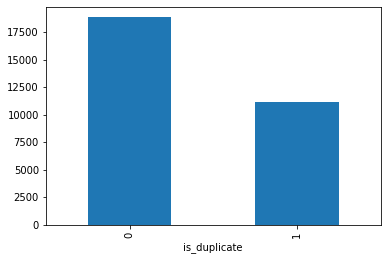

In [7]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [8]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))
print('~> Percentage of Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('~> Percentage of Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Total number of question pairs for training:
   30000
~> Percentage of Question pairs are not Similar (is_duplicate = 0):
   62.78%
~> Percentage of Question pairs are Similar (is_duplicate = 1):
   37.22%


In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

In [10]:
print('Total number of  Unique Questions are: {}'.format(unique_qs))
print('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print('Max number of times a single question is repeated: {}'.format(max(qids.value_counts()))) 

Total number of  Unique Questions are: 55311
Number of unique questions that appear more than one time: 3485 (6.300735839164%)
Max number of times a single question is repeated: 9


In [11]:
q_vals = qids.value_counts()
print(q_vals)

4044      9
8462      9
11264     8
6275      8
11397     7
         ..
117346    1
14132     1
478618    1
425955    1
506297    1
Length: 55311, dtype: int64


In [12]:
q_vals = q_vals.values
print(q_vals)

[9 9 8 ... 1 1 1]


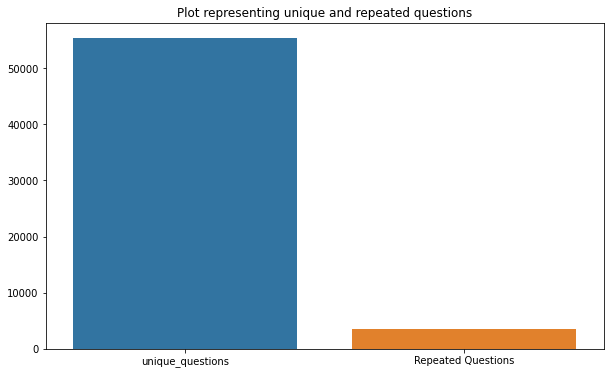

In [13]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions")
sns.barplot(x = x, y = y)
plt.show()

Maximum number of times a single question is repeated: 9



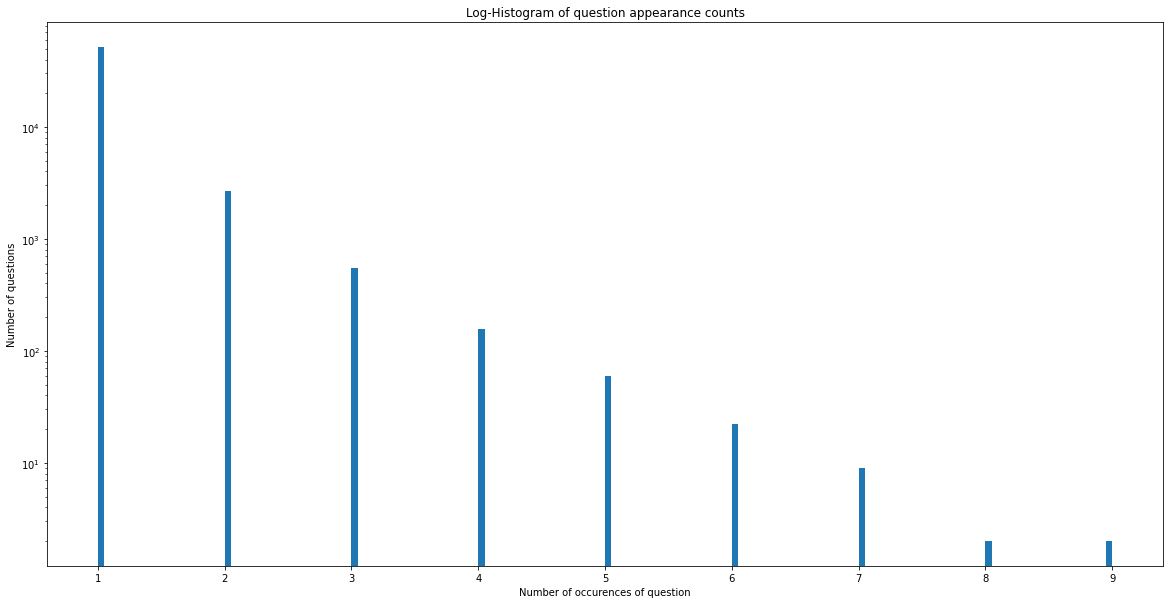

In [14]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [15]:
def data_preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q
    

In [16]:
data_preprocess("I'm going. Please Don't do this <b>.</b>?")

'i am going  please do not do this'

In [17]:
df['question1'] = df['question1'].apply(data_preprocess)
df['question2'] = df['question2'].apply(data_preprocess)

In [18]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1


## Basic Feature Extraction 
Let us now construct a few features like:


q1len = Length of q1

q2len = Length of q2

q1_n_words = Number of words in Question 1

q2_n_words = Number of words in Question 2

word_Common = (Number of common unique words in Question 1 and Question 2)


word_Total =(Total num of words in Question 1 + Total num of words in 
Question 2)

word_share = (word_common)/(word_Total)

freq_qid1 = Frequency of qid1's

freq_qid2 = Frequency of qid2's



freq_q1+freq_q2 = sum total of frequency of qid1 and qid2

freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [19]:
df['q1_len'] = df['question1'].str.len() 
df['q2_len'] = df['question2'].str.len()

In [20]:
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_n_words,q2_n_words
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12


In [21]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [22]:
df['word_common'] = df.apply(common_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_n_words,q2_n_words,word_common
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,2
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,4
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,2
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,6
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,8


In [23]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [24]:
df['word_total'] = df.apply(total_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_n_words,q2_n_words,word_common,word_total
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,2,13
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,4,12
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,2,9
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,6,27
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,8,23


In [25]:
df['word_share'] = round(df['word_common']/df['word_total'],2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_n_words,q2_n_words,word_common,word_total,word_share
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,2,13,0.15
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,4,12,0.33
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,2,9,0.22
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,6,27,0.22
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,8,23,0.35


In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


In [28]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [29]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_n_words,q2_n_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,...,13,0.15,0.999950,0.499988,0.000000,0.000000,0.399992,0.249997,1,0
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,...,12,0.33,0.666644,0.666644,0.999950,0.499988,0.799984,0.571420,1,0
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,...,9,0.22,0.000000,0.000000,0.999950,0.499988,0.666644,0.333328,0,1
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,...,27,0.22,0.666656,0.571420,0.499988,0.222220,0.545450,0.374998,0,0
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,...,23,0.35,0.999975,0.799984,0.666656,0.499994,0.727266,0.666661,1,0


In [30]:
!pip install distance
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    #Find the longest common substring(s) in the sequences `seq1` and `seq2`.
    strs = list(distance.lcsubstrings(q1, q2))
    if len(strs) != 0:
      length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features
    

In [31]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [32]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_n_words,q2_n_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,...,0.499988,0.000000,0.000000,0.399992,0.249997,1,0,3,6.5,0.615385
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,...,0.666644,0.999950,0.499988,0.799984,0.571420,1,0,2,6.0,0.500000
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,...,0.000000,0.999950,0.499988,0.666644,0.333328,0,1,3,4.5,0.476190
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,...,0.571420,0.499988,0.222220,0.545450,0.374998,0,0,5,13.5,0.244444
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,...,0.799984,0.666656,0.499994,0.727266,0.666661,1,0,1,11.5,0.355932


In [33]:
!pip install fuzzywuzzy
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [34]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [35]:
print(df.shape)
df.head()

(30000, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_n_words,q2_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
331535,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,25,43,5,8,...,0.249997,1,0,3,6.5,0.615385,62,76,50,75
45407,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,33,43,5,7,...,0.571420,1,0,2,6.0,0.500000,71,82,66,84
286200,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,20,37,3,6,...,0.333328,0,1,3,4.5,0.476190,67,85,60,60
157195,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,44,72,11,17,...,0.374998,0,0,5,13.5,0.244444,45,55,61,76
154346,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,58,63,11,12,...,0.666661,1,0,1,11.5,0.355932,81,81,78,86


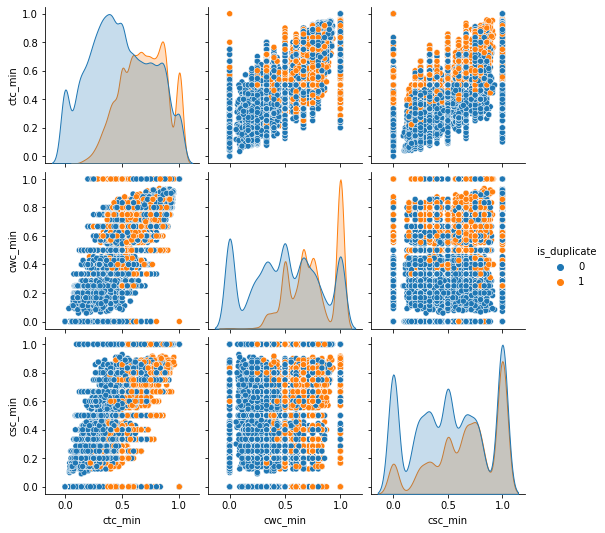

In [36]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

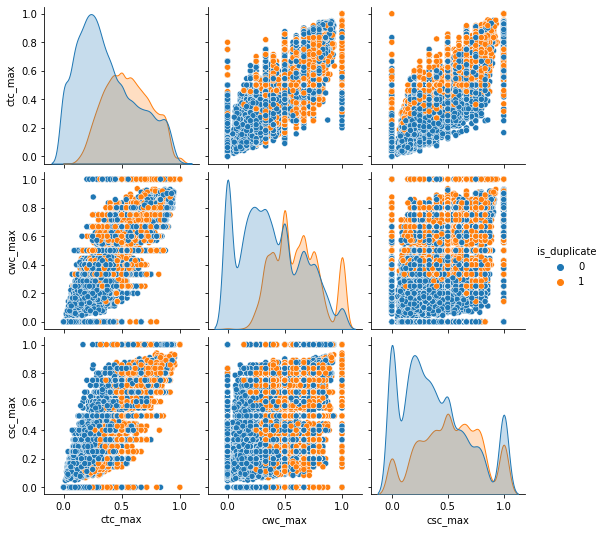

In [37]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

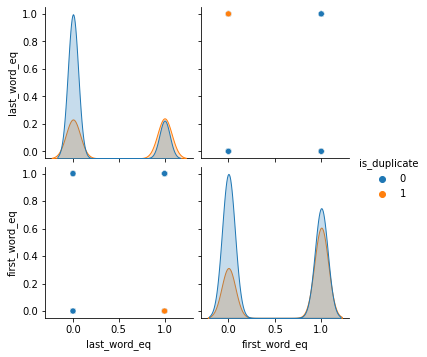

In [38]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

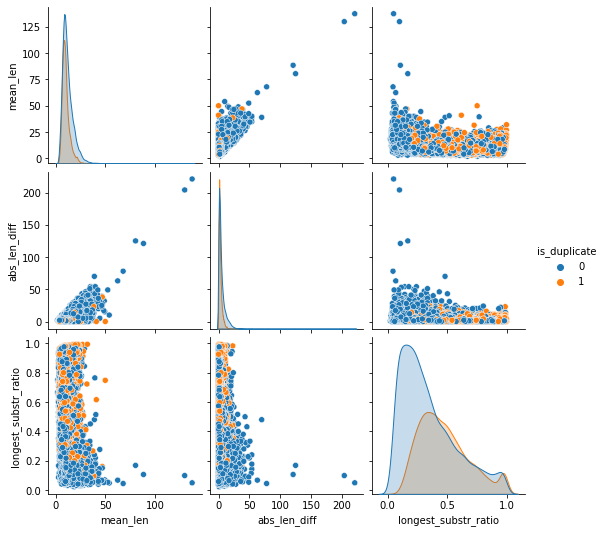

In [39]:
sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

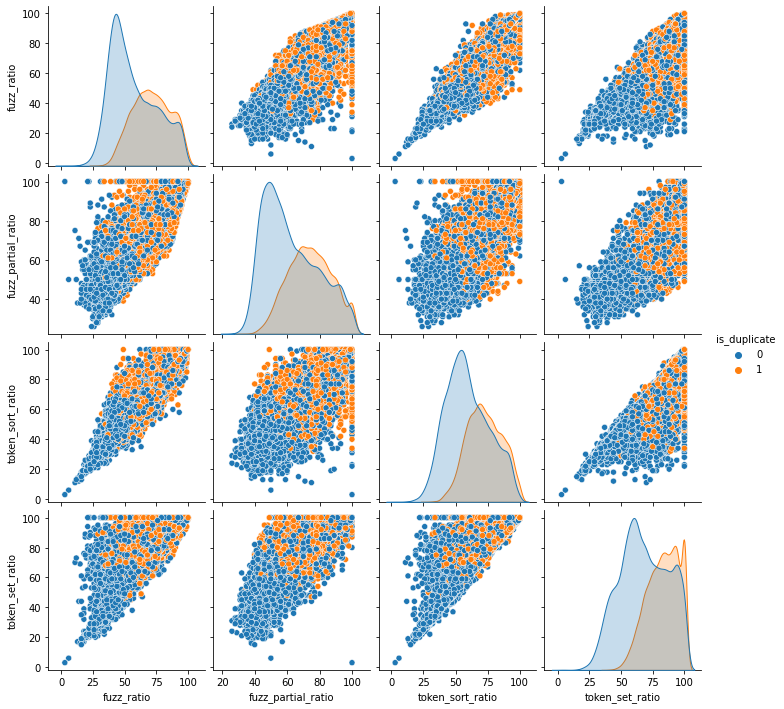

In [40]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [41]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimension


X = MinMaxScaler().fit_transform(df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = df['is_duplicate'].values

In [42]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.062s...
[t-SNE] Computed neighbors for 30000 samples in 6.538s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

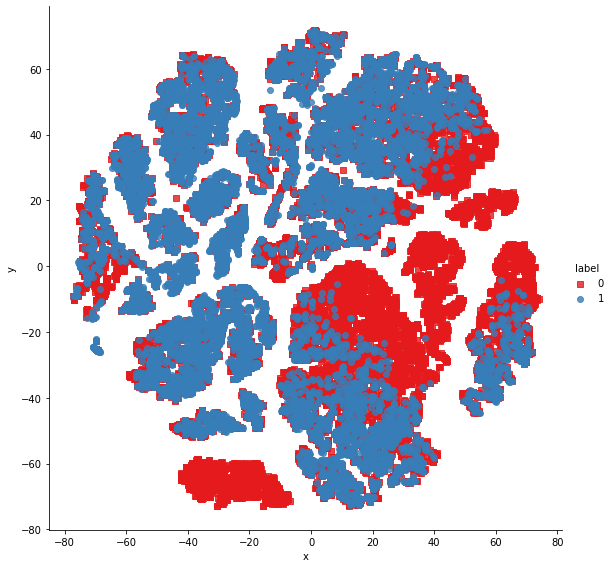

In [43]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])


In [44]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.063s...
[t-SNE] Computed neighbors for 30000 samples in 6.600s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

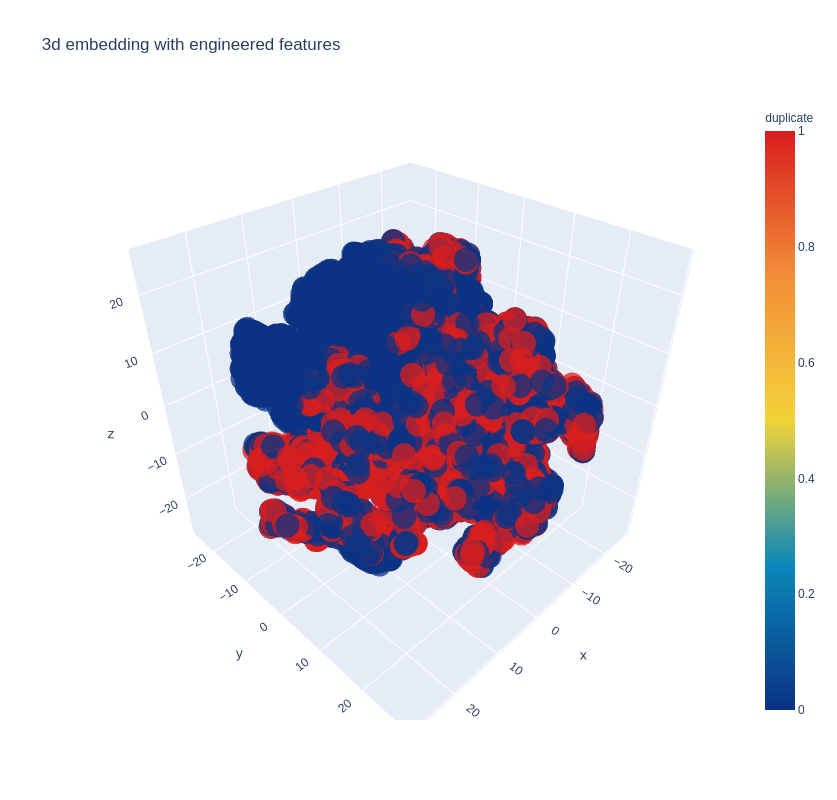

In [89]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [90]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
331535,how can i learn norwegian,what is the quickest way to learn norwegian
45407,how are currency rates determined,where and how are exchange rates determined
286200,what is substitution,what is a substitute for caciocavallo
157195,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...
154346,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...


In [91]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 23)


,is_duplicate,q1_len,q2_len,q1_n_words,q2_n_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
331535,1,25,43,5,8,2,13,0.15,0.999950,0.499988,...,0.249997,1,0,3,6.5,0.615385,62,76,50,75
45407,1,33,43,5,7,4,12,0.33,0.666644,0.666644,...,0.571420,1,0,2,6.0,0.500000,71,82,66,84
286200,0,20,37,3,6,2,9,0.22,0.000000,0.000000,...,0.333328,0,1,3,4.5,0.476190,67,85,60,60
157195,1,44,72,11,17,6,27,0.22,0.666656,0.571420,...,0.374998,0,0,5,13.5,0.244444,45,55,61,76
154346,1,58,63,11,12,8,23,0.35,0.999975,0.799984,...,0.666661,1,0,1,11.5,0.355932,81,81,78,86


In [136]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

count_vect = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(count_vect.fit_transform(questions).toarray(),2)

In [93]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [94]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6023)


,is_duplicate,q1_len,q2_len,q1_n_words,q2_n_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
331535,1,25,43,5,8,2,13,0.15,0.999950,0.499988,...,0,0,0,0,0,0,0,0,0,0
45407,1,33,43,5,7,4,12,0.33,0.666644,0.666644,...,0,0,0,0,0,0,0,0,0,0
286200,0,20,37,3,6,2,9,0.22,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
157195,1,44,72,11,17,6,27,0.22,0.666656,0.571420,...,0,0,0,0,0,0,0,0,0,0
154346,1,58,63,11,12,8,23,0.35,0.999975,0.799984,...,0,0,0,0,0,0,0,0,0,0


In [95]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7878333333333334

In [122]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7806666666666666

In [123]:
from sklearn.metrics import confusion_matrix

In [124]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[3205,  548],
       [ 725, 1522]])

In [125]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[3093,  660],
       [ 656, 1591]])

In [126]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [127]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [128]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


In [129]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [130]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [131]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # data_preprocess
    q1 = data_preprocess(q1)
    q2 = data_preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = count_vect.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = count_vect.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [135]:
q1 = 'What is the capital of India?'
q2 = 'What is the current capital of India?'
q3 = 'Which city serves as the capital of England?'
q4 = 'What is the business capital of India?'

In [140]:
print(count_vect)
rand_forest.predict(query_point_creator(q1,q4))

CountVectorizer(max_features=3000)


array([0])

In [142]:
import pickle

pickle.dump(rand_forest,open('model.pkl','wb'))
pickle.dump(count_vect,open('count_vect.pkl','wb'))